# Week 3 Exercises

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from utils import DiscreteMapping
import copy

# Working with Datasets
See exercise 3.

We have a class for creating and handling our dataset. The class `DiscreteMapping` is imported from the `utils` module. It implements a discrete mapping, like a classification dataset. You give it some input/target prototypes, and it can generate a set of noisy inputs and corresponding targets. The `DiscreteMapping` object stores the inputs and targets.

`DiscreteMapping`
Try the methods:
- ds.plot
- ds.inputs
- ds.targets
- ds.class_mean
- ds.inputs_of_class

You can also use `len(ds)` to get the number of samples. You can access individual input/target samples using index notation, as in `ds[5]`.

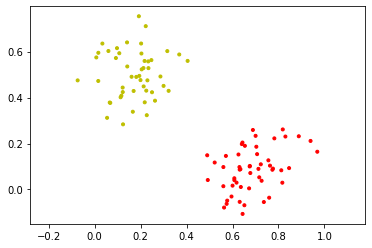

In [26]:
# Create a toy regression dataset
A = np.array([[0.2,0.5],[0.7,0.1]]) # Inputs
B = np.array([[0],[1.]])            # Corresponding targets
ds = DiscreteMapping(A, B, n=100)
ds.plot()

In [27]:
ds[5]

[array([0.64341267, 0.20425839]), array([1.])]

# `Operation`s: Activation/Loss functions
See exercise 4.

The `Operation` class is the base class for activation functions and loss functions.

In [28]:
class Operation(object):
    '''
     Operation class
     
     This is the abstract base class that other operations should be based on.
    '''
    def __init__(self):
        raise NotImplementedError

    def __call__(self, x):
        raise NotImplementedError

    def derivative(self, s):
        raise NotImplementedError

### Activation functions

In [29]:
class Identity(Operation):
    '''
     act = Identity()
     
     Creates an Operation object that represents the identity mapping.
     
     Usage:
      act = Identity()
      act(np.array([[1.2, 5.]]))
     produces the numpy array
      [[1.2, 5.]]
    '''
    def __init__(self):
        return
        
    def __call__(self, z):
        '''
         y = act(z)
         
         Evaluates the identity function, element-by-element, on z.
         
         Input:
          z  is a numpy array
         Output:
          y  is a numpy array the same size as z
        '''
        self.dims = z.shape
        y = copy.deepcopy(z)
        return y
    
    def derivative(self, s=None):
        '''
         act.derivative(s=None)
         
         Computes the derivative of the identity mapping
         element-by-element.
         Note that the __call__ function must be called before this
         function can be called.
         
         Input:
           s       array the same size as z, which multiplies the
                   derivative
           
         Output:
           dactdz  array the same size as z when __call__ was called,
                   and is s times the derivative
           
         Usage:
           dactdz = act.derivative()
           dactdz = act.derivative(s)
        '''
        # Compute the derivatives
        if s is None:
            return np.ones(self.dims)
        else:
            return s
        
class Logistic(Operation):
    '''
     act = Logistic()
     
     Creates an Operation object that represents the logistic
     function.
     
     Usage:
      act = Logistic()
      act(np.array([0., 0.5]))
     produces the numpy array
      [0.5 , 0.62245933]
    '''
    def __init__(self):
        return
        
    def __call__(self, z):
        '''
         y = act(z)
         
         Evaluates the logistic function, element-by-element, on z.
         
         Input:
          z  is a numpy array
         Output:
          y  is a numpy array the same size as z
        '''
        self.dims = z.shape
        self.n_samples = np.shape(z)[0]
        self.dims = np.shape(z)[-1]
        # Logistic forumla [!]
        self.y = 1. / (1. + np.exp(-z))  # Used for derivative [!]
        return self.y
    
    def derivative(self, s=None):
        '''
         act.derivative(s=None)
         
         Computes the derivative of the logistic function
         element-by-element.
         Note that the __call__ function must be called before this
         function can be called.
         
         Input:
           s       array the same size as z, which multiplies the
                   derivative
           
         Output:
           dactdz  array the same size as z when __call__ was called,
                   and is s times the derivative

         Usage:
           dactdz = act.derivative()
           dactdz = act.derivative(s)
        '''
        # Derivatives of logistic [!]
        if s is None:
            return self.y * (1. - self.y)
        else:
            return s * self.y * (1. - self.y)

class Softmax(Operation):
    '''
     act = Softmax()
     Creates an Operation object that represents the softmax
     function. The softmax is applied to the rows of the input.
     Usage:
      act = Softmax()
      act(np.array([[0., 0.5]]))
     produces the numpy array
      [0.5 , 0.62245933]
    '''
    def __init__(self):
        return
    def __call__(self, z):
        v = np.exp(z)
        denom = np.sum(v, axis=1)
        self.y = v/np.tile(denom[:,np.newaxis], [1,np.shape(v)[1]])
        return self.y
    def derivative(self, s):
        '''
         act.derivative(s)
         Computes and the derivative of the softmax function.
         Note that the __call__ function must be called before this
         function can be called.
         Input:
           s       array the same size as z, which multiplies the
                   derivative
                   NOTE: s is a mandatory argument (not optional)
                   NOTE: s should have only a single non-zero element
         Output:
           dactdz  array the same size as z when __call__ was called,
                   and is s times the derivative
         Usage:
           dactdz = act.derivative(s)
        '''
        idx = np.nonzero(s)[1]
        s_gamma = np.zeros_like(s)
        y_gamma = np.zeros_like(self.y)
        kronecker = np.zeros_like(s)
        for k,gamma in enumerate(idx):
            s_gamma[k,:] = s[k,gamma]
            y_gamma[k,:] = self.y[k,gamma]
            kronecker[k,gamma] = 1.
        dydz = s_gamma*y_gamma*(kronecker-self.y)
        return dydz


### Loss functions

In [30]:
class MSE(Operation):
    '''
     E = MSE()
     
     Creates an object that implements the mean squared error loss.
     
     Usage:
      E = MSE()
      loss = E(y, t)
      
     Example:
      y = np.array([[0.5, 0.1],[-0.4, 0.9], [-0.1, 0.4]])
      t = np.array([[0.6, 0.1],[-0.4, 0.7], [-0.1, 0.6]])
      loss = E(y, t)
     produces the value
      0.015  since it equals
      (0.1^2 + 0.2^2 + 0.2^2)/2 / 3
    '''
    def __init__(self):
        self.dE = []
    
    def __call__(self, y, t):
        '''
         E.__call__(y, t)  or   E(y, t)
         
         Computes the mean (average) squared error between the outputs
         y and the targets t.
         
         Inputs:
           y  array with one sample per row
           t  array the same size as y
           
         Output:
           loss  MSE loss (scalar)
        '''
        # MSE formula
        self.n_samples = np.shape(t)[0]
        E = np.sum((y-t)**2)/2./self.n_samples
        self.dE = (y-t) / self.n_samples
        return E

    def derivative(self):
        '''
         E.derivative()
         
         Computes and the derivative of the MSE with respect to y.
         Note that the __call__ function must be called before this
         function can be called.
         
         Output:
           dEdy  array the same size as y when __call__ was called
        '''
        # Compute the gradient of MSE w.r.t. output
        return self.dE

        
class CrossEntropy(Operation):
    '''
     E = CrossEntropy()
     
     Creates an object that implements the average cross-entropy loss.
     
     Usage:
      E = CrossEntropy()
      loss = E(y, t)
    '''
    def __init__(self):
        self.dE = []
    
    def __call__(self, y, t):
        '''
         E.__call__(y, t)  or   E(y, t)
         
         Computes the average cross-entropy between the outputs
         y and the targets t.
         
         Inputs:
           y  array with one sample per row
           t  array the same size as y
           
         Output:
           loss  average CE loss (scalar)
        '''
        n_samples, dim = np.shape(t)
        # Cross Entropy formula [!]
        # Must divide by the number of samples [!]
        E = -np.sum(t*np.log(y)+(1.-t)*np.log(1.-y))/n_samples
        self.dE = (y-t) / y / (1.-y) /n_samples  # Used for derivative
        return E

    def derivative(self):
        '''
         E.derivative()
         
         Computes and the derivative of cross-entropy with respect to y.
         Note that the __call__ function must be called before this
         function can be called.
         
         Output:
           dEdy  array the same size as y when __call__ was called
        '''
        # Compute the gradient of CE w.r.t. output
        return self.dE
        

class CategoricalCE(Operation):
    def __init__(self):
        return
    def __call__(self, y, t):
        self.t = t
        self.y = y
        return -np.sum(t * np.log(y)) / len(t)
    def derivative(self):
        return -self.t/self.y / len(self.t)


# Gradient-Descent Learning
See exercise 5.

## Create the network

This code creates the pieces of the neural network.
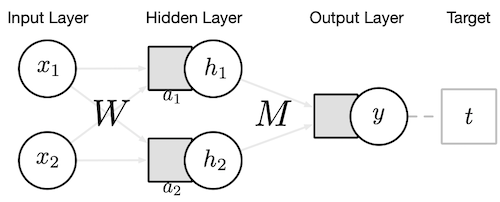

In [31]:
W = np.random.normal(scale=0.1, size=(2,2))  # weights
a = np.random.normal(scale=0.1, size=(1,2))  # biases
sigma1 = Logistic()                          # activation function
M = np.random.normal(scale=0.1, size=(2,1))  # weights
sigma2 = Logistic()                          # activation function
E = CrossEntropy()                           # cost function

# Dataset inputs and targets
x = ds.inputs()
t = ds.targets()

<div class="alert alert-block alert-info">
    Add some code that computes the output y from the input x. Design your code so that it works on the entire input array for the dataset. It should yield y, a 2D array holding the network output for all the samples in the dataset, one per row.
    
Then plot the dataset using

    ds.plot(labels=y)
</div>

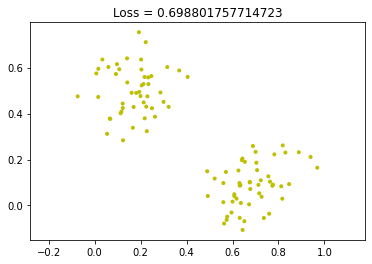

In [32]:
h = sigma1(x@W+a)
y = sigma2(h@M)

ds.plot(labels=y)
loss = E(y, t)
plt.title(f'Loss = {loss}');


## Gradient Descent

<div class="alert alert-block alert-info">
Inside the loop below, perform gradient descent to optimize the average cross-entropy cost (E) by adjusting the weights and biases (W, a, M).
</div>

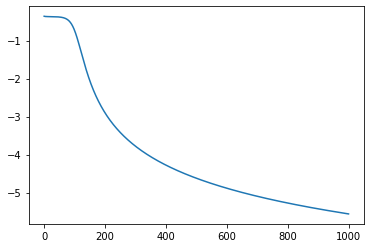

In [33]:
kappa = 1.   # learning rate
losses = []
for idx in range(1000):
    # Evaluate the output of the network
    h = sigma1(x@W+a)
    y = sigma2(h@M)
    
    # Evaluate the cost
    loss = E(y, t)
    
    # Calculate the gradients
    dEdz3 = sigma2.derivative() * E.derivative()
    # Or...
    #dEdz3 = sigma2.derivative(E.derivative())
    
    dEdM = h.T @ dEdz3
    dEdz = sigma1.derivative() * (dEdz3@M.T)
    # Or...
    #dEdz = sigma1.derivative(dEdz3@M.T)
    dEda = np.sum(dEdz, axis=0)
    dEdW = x.T @ dEdz
    
    # Update weights and biases
    W = W - kappa*dEdW
    a = a - kappa*dEda
    M = M - kappa*dEdM
    losses.append(loss)
plt.plot(np.log(losses));


Text(0.5, 1.0, 'Loss = 0.0038325171920121966')

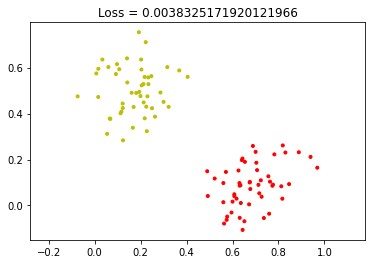

In [34]:
# Run the new network and plot the dataset again
y = sigma2(sigma1(x@W+a)@M)

ds.plot(labels=y);
loss = E(y,t)
plt.title(f'Loss = {loss}')


# Implementing Neural Networks
These exercises are designed to get you comfortable with the code base that we will use to implement our neural networks.

## `Layer` Classes
See exercise 6.

The `Layer` class is an abstract base class for other types of layers.

<div class="alert alert-block alert-info">
    Complete the implementation of <code>DenseLayer.__call__</code>.
</div>

In [35]:
class Layer(object):
    def __init__(self):
        return

    def __call__(self, x):
        raise NotImplementedError


class Population(Layer):
    '''
     lyr = Population(nodes, act=Identity())

     Creates a Population layer object.

     Inputs:
       nodes  the number of nodes in the population
       act    activation function (Operation object)
       
     Usage:
       lyr = Population(3, act=Logistic())
       h = lyr(z)
       print(lyr())   # prints current value of lyr.h
    '''

    def __init__(self, nodes, act=Identity()):
        self.nodes = nodes
        self.z = None
        self.h = None
        self.act = act
        self.params = []

    def __call__(self, x=None):
        if x is not None:
            self.z = x
            self.h = self.act(x)
        return self.h


class Connection(Layer):
    '''
     lyr = Connection(from_nodes=1, to_nodes=1)

     Creates a layer of all-to-all connections.

     Inputs:
       from_nodes  number of nodes in source layer
       to_nodes    number of nodes in receiving layer

     Usage:
       lyr = Connection(from_nodes=3, to_nodes=5)
       z = lyr(h)
       lyr.W    # matrix of connection weights
       lyr.b    # vector of biases
    '''

    def __init__(self, from_nodes=1, to_nodes=1):
        super().__init__()

        self.W = np.random.randn(from_nodes, to_nodes) / np.sqrt(from_nodes)
        self.b = np.zeros(to_nodes)
        self.params = [self.W, self.b]

    def __call__(self, x=None):
        if x is None:
            print('Should not call Connection without arguments.')
            return
        P = len(x)
        if P>1:
            return x@self.W + np.outer(np.ones(P), self.b)
        else:
            return x@self.W + self.b


class DenseLayer(Layer):
    '''
     lyr = DenseLayer(from_nodes=1, to_nodes=1, act=Logistic())

     Creates a DenseLayer object, composed of 2 layer objects:
       L1  a Connection layer of connection weights, and
       L2  a Population layer, consisting of nodes that receives current
           from the Connection layer, and apply the activation function

     Inputs:
       from_nodes  how many nodes are in the layer below
       to_nodes    how many nodes are in the new Population layer
       act         activation function (Operation object)
       
     Usage:
       lyr = DenseLayer(from_nodes=3, to_nodes=5)
       h2 = lyr(h1)
       lyr.L1.W        # connection weights
       lyr.L2()        # activities of layer
       lyr.L2.act      # activation function of layer
    '''

    def __init__(self, from_nodes=1, to_nodes=1, act=Logistic()):
        self.L1 = Connection(from_nodes=from_nodes, to_nodes=to_nodes)
        self.L2 = Population(from_nodes, act=act)

    def __call__(self, x=None):
        if x is None:
            return self.L2.h
        else:
            # Calculate and return the operation of the two layers, L1 and L2
            return self.L2(self.L1(x))


### Create a small dataset to play with

Input prototypes (in rows): 
[[-0.85566197 -0.68200908]
 [-0.42798115  0.35587317]
 [ 0.42402296  0.64205307]]
Corresponding targets: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


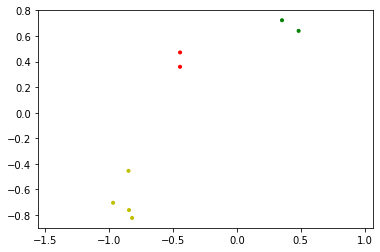

In [36]:
# This creates a dataset
n_classes = 3
in_dim = 2

np.random.seed(250)
B = np.eye(n_classes)
A = 3.*(np.random.rand(n_classes, in_dim) - 0.5)

print(f'Input prototypes (in rows): \n{A}')
print(f'Corresponding targets: \n{B}')

ds = DiscreteMapping(A, B, n=8, noise=0.1)
ds.plot()

<div class="alert alert-block alert-info">
    Create a <code>Population</code> layer object and feed <code>x.inputs()</code> through it.
</div>

In [37]:
lyr1 = Population(2, act=Logistic())  # layer with 2 nodes
print(lyr1(ds.inputs()))


[[0.39086234 0.58885567]
 [0.30014198 0.38834177]
 [0.30614008 0.30526132]
 [0.61852037 0.65475242]
 [0.30099645 0.31842782]
 [0.58746273 0.67328247]
 [0.27545583 0.33094108]
 [0.39093512 0.61570847]]


<div class="alert alert-block alert-info">
    Create a <code>Connection</code> layer and look at the matrix of connection weights. Then feed the output from your <code>Population</code> layer through your <code>Connection</code> layer.
</div>

In [38]:
lyr2 = Connection(from_nodes=2, to_nodes=5)
print(lyr2.W)


[[-0.03472779 -0.67733284  0.55898317  0.59521867  0.33620673]
 [-0.74759454 -0.47293313 -0.69301845 -0.12666031  0.2659984 ]]


In [39]:
y = lyr2(lyr1(ds.inputs()))
print(y)


[[-0.45379907 -0.54323326 -0.18960238  0.15806392  0.28804521]
 [-0.30074545 -0.38695571 -0.1013537   0.12946262  0.20420804]
 [-0.23884326 -0.35172692 -0.04042457  0.1435558   0.18412538]
 [-0.51096918 -0.72859828 -0.10801303  0.28522372  0.38211381]
 [-0.24850784 -0.35446985 -0.05242441  0.13882654  0.18589832]
 [-0.52374358 -0.71632539 -0.1382154   0.26439061  0.37660098]
 [-0.25697572 -0.34308829 -0.0753731   0.12203935  0.1806399 ]
 [-0.4738766  -0.55598213 -0.20817118  0.15470605  0.29521248]]


<div class="alert alert-block alert-info">
    Create a <code>DenseLayer</code> object and look at the matrix of connection weights, and feed <code>ds.inputs()</code> through it.
</div>

In [40]:
lyr3 = DenseLayer(from_nodes=2, to_nodes=5, act=Logistic())
print(lyr3.L1.W)
y = lyr3(ds.inputs())
print(y)


[[ 0.55624736  0.22872639  0.15331683  1.1473253  -0.78114962]
 [ 0.78839565 -0.22517634  0.57945393 -0.14770358 -0.11754094]]
[[0.50910399 0.45453221 0.53497683 0.363058   0.57550858]
 [0.30383757 0.4771784  0.40298563 0.28817776 0.67144674]
 [0.24908695 0.49950689 0.35389263 0.30633577 0.67608109]
 [0.68425349 0.49160714 0.6094359  0.61300026 0.38871095]
 [0.25566097 0.49466158 0.36120306 0.29853497 0.6786583 ]
 [0.68280449 0.47951986 0.61613628 0.5741403  0.41068948]
 [0.25106654 0.48433112 0.36443386 0.26783736 0.69808654]
 [0.53120863 0.44829666 0.55111094 0.35931739 0.572227  ]]


## `Network` Class
See exercise 7.

In [41]:
class Network(object):
    '''
     net = Network()

     Creates a Network object.
     
     Usage:
       net = Network()
       net.add_layer(L)
       ... (add more layers)
       y = net(x)
       net.lyr[1]    # reference to Layer object
    '''

    def __init__(self):
        self.lyr = []
        self.loss = None

    def add_layer(self, L):
        '''
         net.add_layer(L)
         
         Adds the layer object L to the network.
         
         Note: It is up to the user to make sure the Layer object
               fits with adjacent layers.
        '''
        self.lyr.append(L)

    def __call__(self, x):
        '''
         y = net(x)
         
         
         Input:
           x  batch of inputs, one input per row
           
         Output:
           y  corresponding outputs, one per row
        '''
        for l in self.lyr:
            x = l(x)
        return x


<div class="alert alert-block alert-info">
    Create a small network and feed some data through it. Evaluate a cost function on its output.
</div>

In [42]:
net = Network()
input_layer = Population(2, act=Identity())
net.add_layer(input_layer)
hidden_layer = DenseLayer(from_nodes=2, to_nodes=5, act=Logistic())
net.add_layer(hidden_layer)
output_layer = DenseLayer(from_nodes=5, to_nodes=3, act=Logistic())
net.add_layer(output_layer)

net.loss = CrossEntropy()

y = net(ds.inputs())
print(y)

print(net.loss(y, ds.targets()))


[[0.62676509 0.57932741 0.51101342]
 [0.55883494 0.49259483 0.49912777]
 [0.534934   0.48059378 0.50046509]
 [0.66629081 0.66047016 0.52821359]
 [0.53865919 0.48128196 0.49990563]
 [0.66951925 0.65722638 0.52637777]
 [0.54193834 0.47795966 0.49817279]
 [0.63511647 0.58854428 0.51207396]]
2.2481169804984944


In [44]:
isinstance(input_layer, Population)

True

# Gradient descent demo
A simple scalar example.

In [19]:
def f(x):
    return x**2

def dfdx(x):
    return 2*x

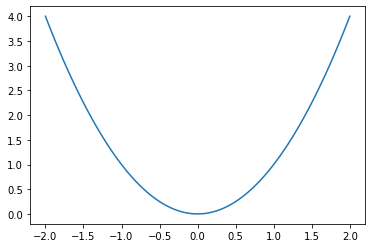

In [20]:
xx = np.linspace(-2, 2, 100)
yy = f(xx)
plt.plot(xx,yy);

In [21]:
x = 0.2
y = f(x)
hist = [(x,y)]
kappa = 1.2
iters = 8
for n in range(iters):
    x -= kappa*dfdx(x)
    y = f(x)
    hist.append((x,y))
hist = np.array(hist)

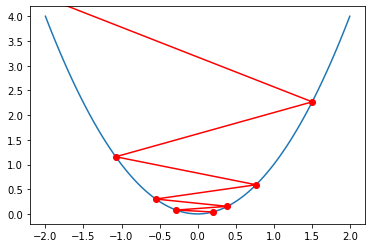

In [22]:
plt.plot(xx,yy)
ax = plt.axis()
plt.plot(hist[:,0], hist[:,1], 'ro-');
plt.axis(ax);